In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

root = "/Users/zyxu/Documents/py/FM_weights"
os.chdir(root)

In [8]:
# model = "vit_tiny_patch16_384_in21k"
# model = "vit_tiny_in21k"
# model = "vit_small_in21k"
model = "vit_small_in1k"
loaded_tensor = torch.load(f'{root}/output/{model}/37_4sets_intermediate_outputs.pth')
print(loaded_tensor.shape)

torch.Size([13, 256, 197, 384])


In [9]:
from utils import intermdiates_to_pos_ctx
res = intermdiates_to_pos_ctx(loaded_tensor, normalize = False)
res.keys()

mu.shape torch.Size([13, 384])
expanded_mu_pos:  torch.Size([13, 197, 384])
expanded_mu_ctx:  torch.Size([13, 256, 384])
expanded_pos: torch.Size([13, 256, 197, 384]), expanded_ctx: torch.Size([13, 256, 197, 384]), expanded_mu_whole: torch.Size([13, 256, 197, 384])
resid: torch.Size([13, 256, 197, 384])
cvec: torch.Size([13, 256, 197, 384])


dict_keys(['mu', 'pos', 'ctx', 'resid', 'cvec'])

In [10]:
res['pos'].shape

torch.Size([13, 197, 384])

### PCA

In [11]:
D = loaded_tensor.shape[-1]
D

384

Layer progress: 100%|██████████| 12/12 [00:00<00:00, 32.80it/s]


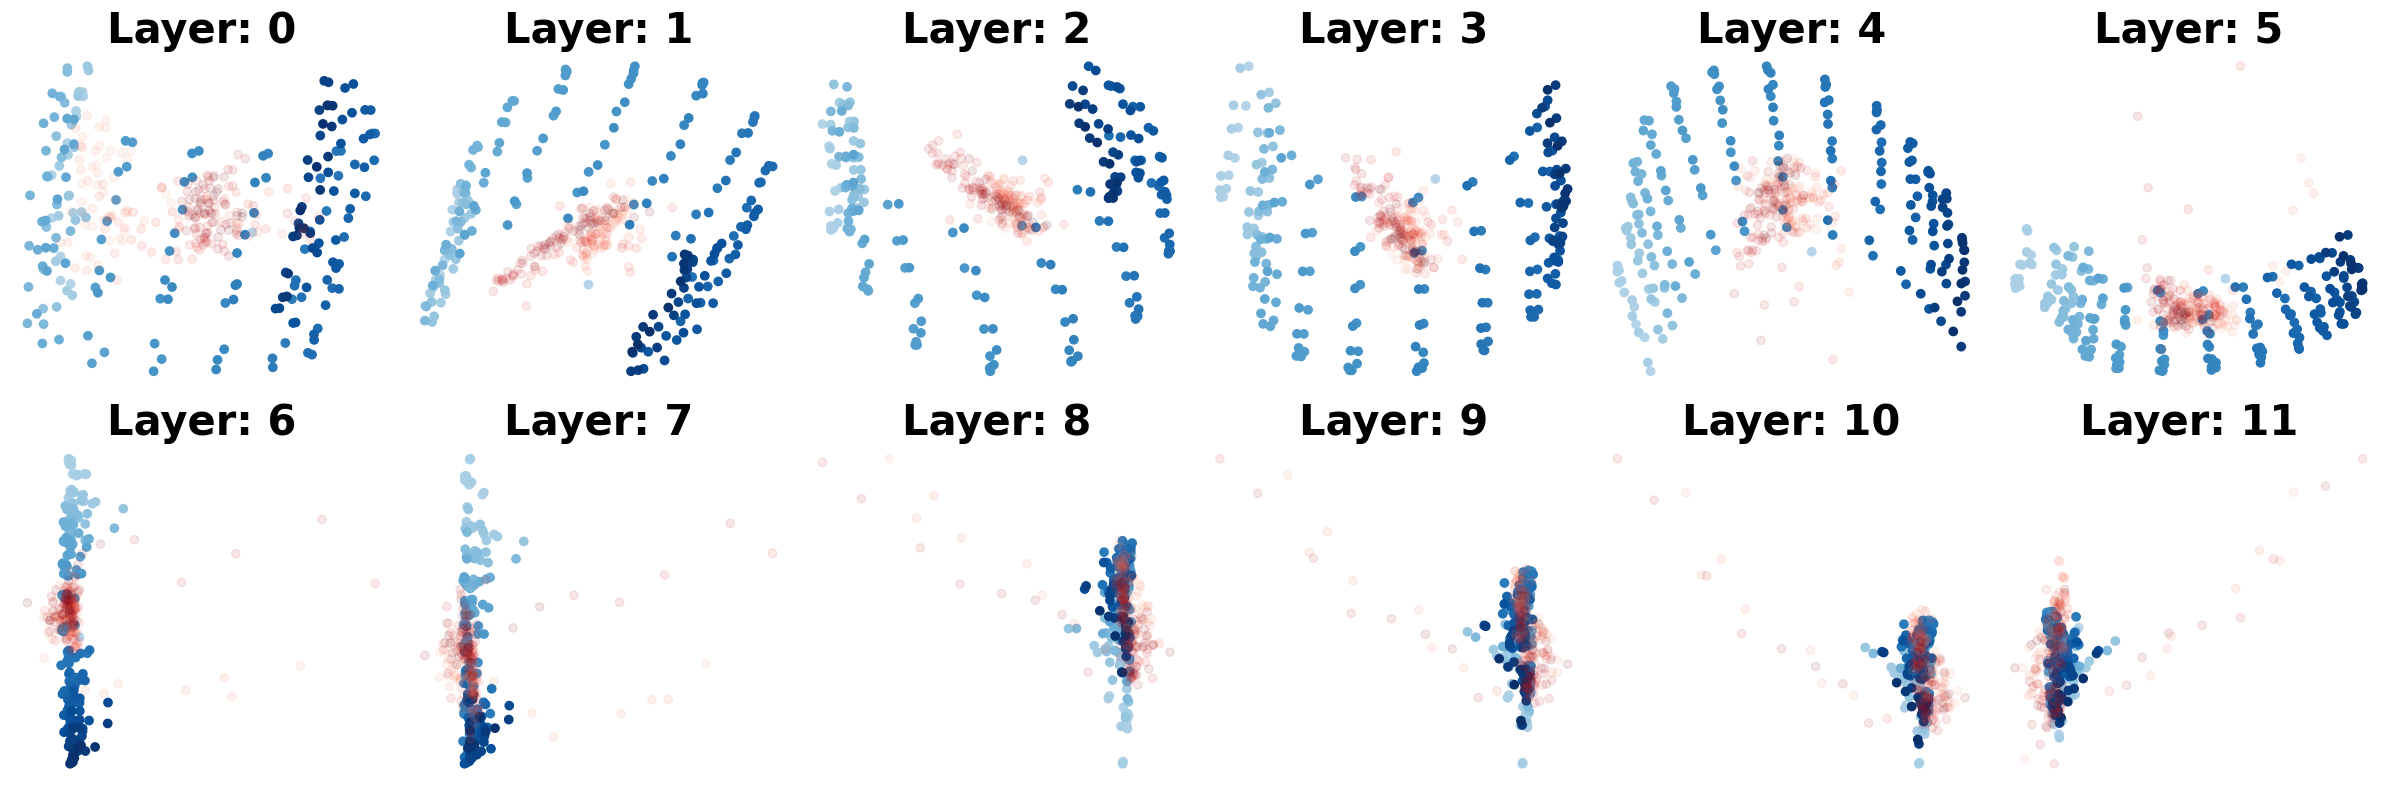

In [12]:
from utils import visz_pca_pos_cvec

visz_pca_pos_cvec.plot(res['pos'].detach(),res['cvec'].detach().view(13,-1,D), plot_context=True)

Layer progress: 100%|██████████| 12/12 [00:00<00:00, 32.94it/s]


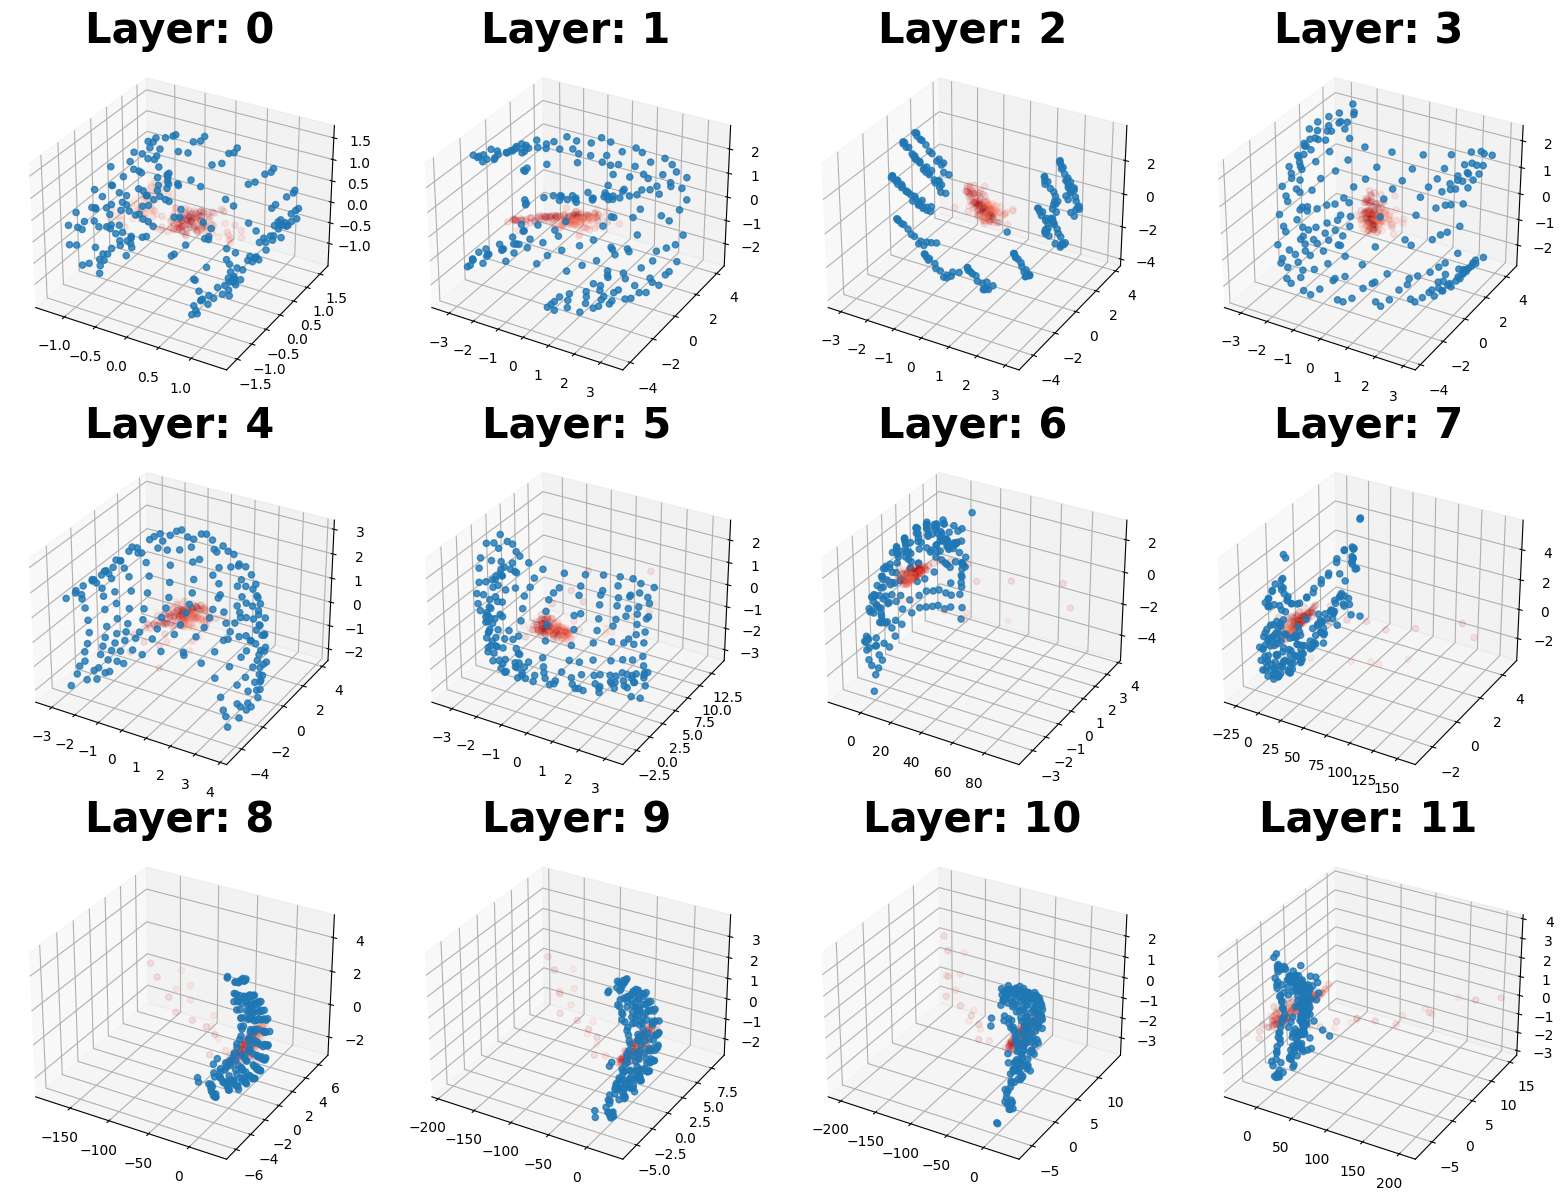

In [13]:
visz_pca_pos_cvec.plot3D(res['pos'].detach(),res['cvec'].detach().view(13,-1,D), plot_context=True, remove_axis=False)

## find outliers

In [14]:
pos = res['pos'].detach()
layer_idx = 7
p = pos[layer_idx]
print("p shape: ", p.shape) # [197, 192]

# apply PCA
u, s, vt = np.linalg.svd(p)
proj_mat = vt[:3, :].T

print("proj_mat shape: ", proj_mat.shape) # [192, 3]
pc = p @ proj_mat

pc = pc.detach().numpy()
print("pc shape: ", pc.shape)

p shape:  torch.Size([197, 384])
proj_mat shape:  (384, 3)
pc shape:  (197, 3)


In [19]:
# Assuming `pc` is the projected positional embeddings with shape [T, 3] where T is the sequence length
mean = np.mean(pc, axis=0)
std_dev = np.std(pc, axis=0)

# Define an outlier as any point more than 'n' standard deviations from the mean
n = 4 # This is an arbitrary choice and could be adjusted
outliers = np.where(np.abs(pc - mean) > n * std_dev)[0]

# `outliers` now contains the indices of the outliers in the PC space
outliers

array([26, 41])

In [28]:
pc[outliers]

array([], shape=(0, 3), dtype=float32)

## consistent outliers

In [29]:
seed_numSet = [
    (37, "Cifar10"),
    (37, "DTD"),
    (37, "STL10"),
    (37, "tieredImageNet"),
    (37, "4sets"),
    (42, "4sets"),
]

In [30]:
from utils import intermdiates_to_pos_ctx
for seed, numSet in seed_numSet:
    print(f"======== seed {seed} | numSet {numSet} ========")
    
    ## load res
    loaded_tensor = torch.load(f'{root}/output/{model}/{seed}_{numSet}_intermediate_outputs.pth')
    res = intermdiates_to_pos_ctx(loaded_tensor, normalize = False, verbose=False)


    
    pos = res['pos'].detach()

    for layer_idx in range(7,12):
        
        p = pos[layer_idx]

        # apply PCA
        u, s, vt = np.linalg.svd(p)
        proj_mat = vt[:3, :].T

        pc = p @ proj_mat

        pc = pc.detach().numpy()
        # Assuming `pc` is the projected positional embeddings with shape [T, 3] where T is the sequence length
        # Calculate the Euclidean distance from the mean for each point
        mean = np.mean(pc, axis=0)
        distances = np.sqrt(np.sum((pc - mean) ** 2, axis=1))

        # Sort the distances and get the indices of the two largest
        sorted_indices = np.argsort(distances)  # Sorts in ascending order
        two_extreme_outliers = sorted_indices[-5:]  # Take the last two indices for the most extreme values


        print(f"layer {layer_idx}: {two_extreme_outliers}")


======== seed 37 | numSet Cifar10 ========
layer 7: [  0  14   1 196 183]
layer 8: [ 23  14 196   1 183]
layer 9: [ 23  14 196   1 183]
layer 10: [ 19  14 196   1 183]
layer 11: [ 23  14 196   1 183]
======== seed 37 | numSet DTD ========
layer 7: [  0 183  14 196   1]
layer 8: [ 52 183   1  14 196]
layer 9: [ 52 183   1  14 196]
layer 10: [ 52 183   1  14 196]
layer 11: [ 52 183   1  14 196]
======== seed 37 | numSet STL10 ========
layer 7: [ 13 183 196   1  14]
layer 8: [180 183 196  14   1]
layer 9: [180 183 196  14   1]
layer 10: [180 183 196  14   1]
layer 11: [180 183 196  14   1]
======== seed 37 | numSet tieredImageNet ========
layer 7: [  0 183   1  14 196]
layer 8: [ 17   1  14 183 196]
layer 9: [ 26   1  14 183 196]
layer 10: [ 26   1  14 183 196]
layer 11: [ 17   1  14 183 196]
======== seed 37 | numSet 4sets ========
layer 7: [  0   1  14 183 196]
layer 8: [ 19  14   1 196 183]
layer 9: [ 20  14   1 196 183]
layer 10: [ 30  14   1 196 183]
layer 11: [ 30  14   1 196 183]
=

In [31]:
import numpy as np
pc = np.arange(15).reshape(5,3)
print("pc: ", pc)
mean = np.mean(pc, axis=0)
mean


pc:  [[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]]


array([6., 7., 8.])

In [5]:
distances = np.sqrt(np.sum((pc - mean) ** 2, axis=1))
distances

array([10.39230485,  5.19615242,  0.        ,  5.19615242, 10.39230485])

In [6]:
(pc - mean) ** 2

array([[36., 36., 36.],
       [ 9.,  9.,  9.],
       [ 0.,  0.,  0.],
       [ 9.,  9.,  9.],
       [36., 36., 36.]])